# LSTM Bottleneck Prediction

## Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

## Synthetic Data Generation

This section simulates a realistic time-series dataset representing server resource usage over time. The goal is to generate data that mimics real-world system behavior to train an LSTM model for bottleneck prediction.

### Simulation Parameters

| Parameter         | Description                                 |
|------------------|---------------------------------------------|
| `NUM_SERVERS`     | Number of simulated servers                |
| `SIM_TIME`        | Total simulated duration (in time units)   |
| `TASK_INTERVAL`   | Mean inter-arrival time for new tasks      |
| `CPU_CAPACITY`    | Max CPU usage (100%)                       |
| `NET_CAPACITY`    | Max network bandwidth (100%)               |

---


In [ ]:
NUM_SERVERS = 3
SIM_TIME = 500  # total time to simulate (not # of rows)
TASK_INTERVAL = 1.0  # average interval between tasks
CPU_CAPACITY = 100
NET_CAPACITY = 100

### Poisson-Based Task Arrival

Task arrival times are based on a Poisson process, simulated using the exponential distribution:

\[
\text{Interarrival Time} \sim \text{Exponential}(\lambda = \frac{1}{\text{TASK\_INTERVAL}})
\]

This introduces realistic irregularity in task arrivals — mimicking user requests, job submissions, or packet arrivals.

### Time-Varying Resource Usage Patterns

We simulate periodic system load using sinusoidal functions:

#### 🔹 CPU Usage

\[
\text{cpu\_base}(t) = 50 + 40 \cdot \sin\left(\frac{2\pi t}{\text{PERIOD}}\right)
\]

#### 🔹 Network In/Out

\[
\text{net\_base}(t, s) = 30 + 25 \cdot \sin\left(\frac{2\pi (t + s \cdot 10)}{\text{PERIOD}}\right)
\]

Where:
- \( t \): current timestamp
- \( s \): server index (adds phase shift between servers)
- `PERIOD`: defines workload cycle length (e.g. peaks every 100 time units)

These trends simulate diurnal load patterns, cyclic CPU spikes, and network traffic fluctuations.

### Gaussian Noise for Realism

We inject Gaussian noise to simulate sensor or monitoring variability:

\[
\text{cpu} = \text{clip}\left(\text{cpu\_base} + \mathcal{N}(0, 10), 0, 100\right)
\]

\[
\text{net\_in}, \text{net\_out} = \text{clip}\left(\text{net\_base} + \mathcal{N}(0, 5), 0, 100\right)
\]

This produces "wobble" on top of clean trends — like real monitoring data.

### Scheduled Bottlenecks

At specific intervals (e.g., \( t = 250 \) to \( 260 \) on Server 1), we introduce high-load conditions:

- CPU, Net In, and Net Out are all set to ≥ 90%
- Ensures predictable bottlenecks for model learning/testing

### Bottleneck Label Definition

A binary bottleneck label is assigned based on 80% utilization threshold:

\[
\text{bottleneck} =
\begin{cases}
1, & \text{if CPU} \geq 80 \text{ or Net In/Out} \geq 80 \\
0, & \text{otherwise}
\end{cases}
\]


In [ ]:
records = []
timestamp = 0.0  # start time

while timestamp < SIM_TIME:
    # Exponentially distributed inter-arrival time
    timestamp += random.expovariate(1.0 / TASK_INTERVAL)
    for s in range(NUM_SERVERS):
        # CPU/net patterns
        cpu_base = 50 + 40 * np.sin(2 * np.pi * timestamp / 100)
        net_base = 30 + 25 * np.sin(2 * np.pi * (timestamp + s*10) / 100)

        # Add noise
        cpu = int(np.clip(cpu_base + random.gauss(0, 10), 0, CPU_CAPACITY))
        net_in = int(np.clip(net_base + random.gauss(0, 5), 0, NET_CAPACITY))
        net_out = int(np.clip(net_base + random.gauss(0, 5), 0, NET_CAPACITY))
        q_len = int(np.clip(cpu / 10 + random.gauss(0, 2), 0, 10))

        # Inject synthetic bottleneck
        if 250 <= timestamp <= 260 and s == 1:
            cpu = 95
            net_in = 90
            net_out = 90

        bottleneck = int(
            cpu >= 0.8 * CPU_CAPACITY or
            net_in >= 0.8 * NET_CAPACITY or
            net_out >= 0.8 * NET_CAPACITY
        )

        records.append({
            'timestamp': round(timestamp, 2),
            'server_id': f'Server {s}',
            'cpu_used': cpu,
            'q_len': q_len,
            'network_in': net_in,
            'network_out': net_out,
            'bottleneck': bottleneck
        })

# Save dataset
df = pd.DataFrame(records)
df.to_csv('synthetic_realistic_poisson.csv', index=False)

print("Generated with Poisson-style timestamps:")
print(df.head())

Generated with Poisson-style timestamps:
   timestamp server_id  cpu_used  q_len  network_in  network_out  bottleneck
0       0.26  Server 0        68      4          33           28           0
1       0.26  Server 1        42      2          47           41           0
2       0.26  Server 2        42      3          55           57           0
3       0.37  Server 0        55      7          29           39           0
4       0.37  Server 1        50      4          48           42           0


### Visualising The Dataset
Plotting the Time Series

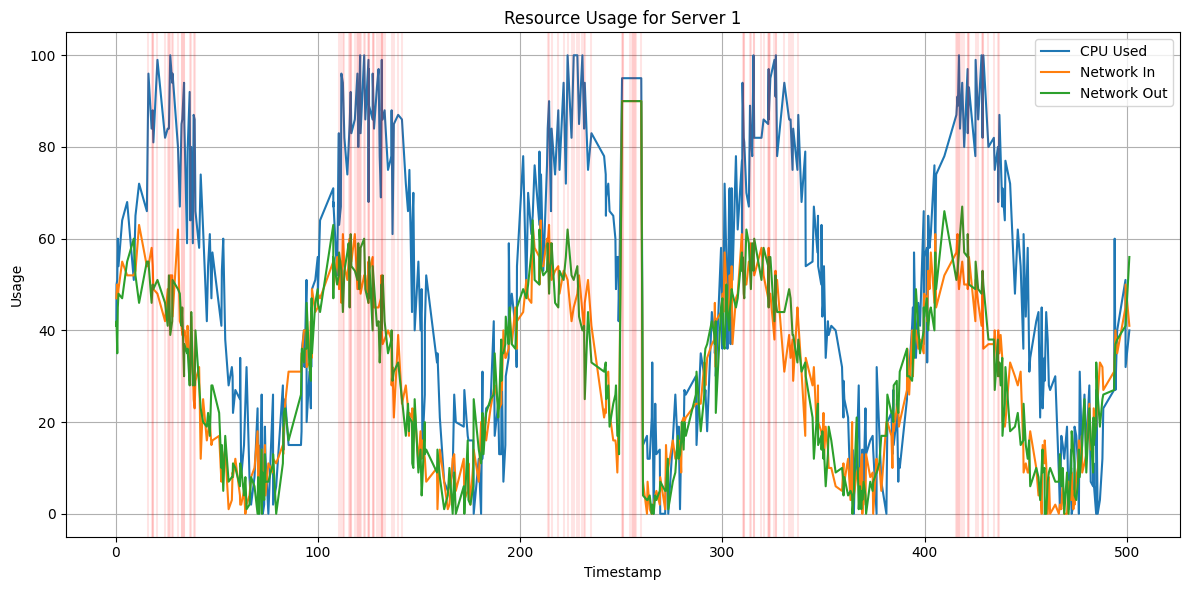

In [ ]:
df = pd.read_csv('synthetic_realistic_poisson.csv')

# plotting for single server
server = 'Server 1'
server_df = df[df['server_id'] == server]

# Plot CPU, network_in, network_out
plt.figure(figsize=(12, 6))
plt.plot(server_df['timestamp'], server_df['cpu_used'], label='CPU Used')
plt.plot(server_df['timestamp'], server_df['network_in'], label='Network In')
plt.plot(server_df['timestamp'], server_df['network_out'], label='Network Out')

# Mark bottlenecks
bottleneck_times = server_df[server_df['bottleneck'] == 1]['timestamp']
for bt in bottleneck_times:
    plt.axvline(bt, color='red', alpha=0.1)

plt.title(f'Resource Usage for {server}')
plt.xlabel('Timestamp')
plt.ylabel('Usage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Data Preprocessing

Import Libraries

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Split into dependent and independent variablesm normalise

In [ ]:
df = pd.read_csv('synthetic_realistic_poisson.csv')

# Features & Target
FEATURES = ['cpu_used', 'q_len', 'network_in', 'network_out']
TARGET = 'bottleneck'
WINDOW_SIZE = 20  # Number of timesteps to look back

# Normalize features (per column)
scaler = MinMaxScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

# Create sequences
X, Y = [], []

for server_id in df['server_id'].unique():
    server_df = df[df['server_id'] == server_id].reset_index(drop=True)

    for i in range(len(server_df) - WINDOW_SIZE):
        window = server_df.loc[i:i + WINDOW_SIZE - 1, FEATURES].values
        label = server_df.loc[i + WINDOW_SIZE, TARGET]
        X.append(window)
        Y.append(label)

X = np.array(X)
Y = np.array(Y)

print(f"Shape of X: {X.shape} | Shape of Y: {Y.shape}")

Shape of X: (1464, 20, 4) | Shape of Y: (1464,)


## LSTM Model Definition, Training and Evaluation

### Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

### LSTM Model Definition


In [ ]:
# Define model
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,777 (77.25 KB)

 Trainable params: 19,777 (77.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train/Test Split & Training

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7486 - loss: 0.6376 - val_accuracy: 0.7702 - val_loss: 0.5955
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7988 - loss: 0.4958 - val_accuracy: 0.7702 - val_loss: 0.3558
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8208 - loss: 0.3243 - val_accuracy: 0.7702 - val_loss: 0.3413
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8133 - loss: 0.3120 - val_accuracy: 0.8681 - val_loss: 0.3011
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8459 - loss: 0.2967 - val_accuracy: 0.8383 - val_loss: 0.2896
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8561 - loss: 0.2384 - val_accuracy: 0.8511 - val_loss: 0.2859
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8585 - loss: 0.2680 - val_accuracy: 0.8511 - val_loss: 0.2734
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8645 - loss: 0.2649 - val_accuracy: 0.8298 - v

### Evaluation and Visualisation

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       235
           1       0.69      0.78      0.73        58

    accuracy                           0.89       293
   macro avg       0.82      0.85      0.83       293
weighted avg       0.89      0.89      0.89       293

[[215  20]
 [ 13  45]]


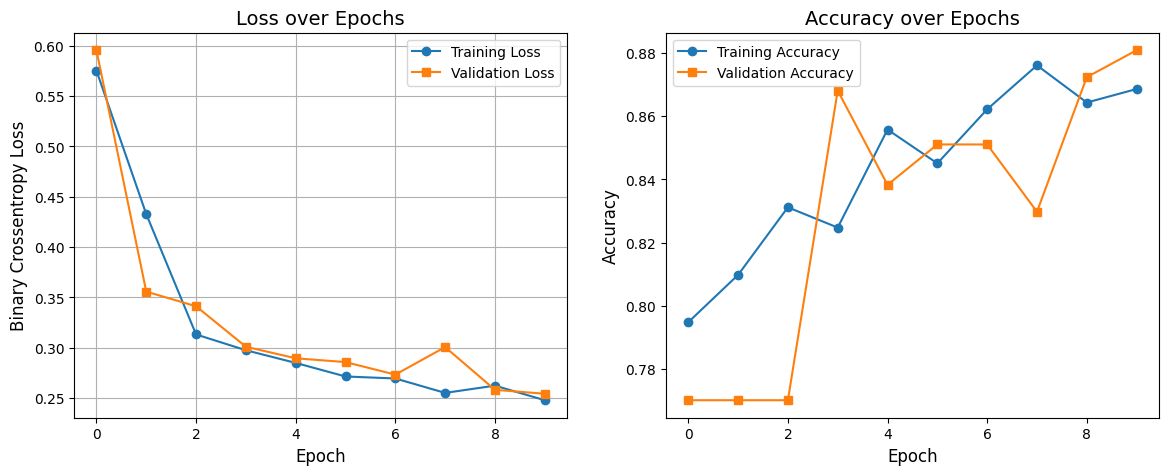

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
# --- Plot 1: Loss ---
axs[0].plot(history.history['loss'], label='Training Loss', marker='o')
axs[0].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axs[0].set_title('Loss over Epochs', fontsize=14)
axs[0].set_xlabel('Epoch', fontsize=12)
axs[0].set_ylabel('Binary Crossentropy Loss', fontsize=12)
axs[0].legend()
axs[0].grid(True)

# --- Plot 2: Accuracy ---
axs[1].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axs[1].set_title('Accuracy over Epochs', fontsize=14)
axs[1].set_xlabel('Epoch', fontsize=12)
axs[1].set_ylabel('Accuracy', fontsize=12)
axs[1].legend()

# Evaluate
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))